In [10]:
# coding: utf-8
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import cv2
from model import build_model
import matplotlib.pyplot as plt
import processing
from sklearn.metrics import mean_squared_error
import argparse
from model import build_model
import os
import pandas as pd
from pandas import Series
import pickle
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import keras.backend.tensorflow_backend as KTF
%matplotlib inline

In [11]:
if '__file__' not in globals():
    CURRENT_DIR = os.getcwd()
else:
    CURRENT_DIR = os.path.dirname(os.path.realpath(__file__))
SAVES = os.path.join(CURRENT_DIR, 'saves')
DATA_PATH =  os.path.join(CURRENT_DIR, 'data')
PREPARED_DATA_PATH = os.path.join(DATA_PATH, 'prepared-data')
FLOW_IMGS_TRAIN = os.path.join(PREPARED_DATA_PATH, 'flow_train_imgs')
TRAIN_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'train_flow_meta.csv')
FLOW_IMGS_TEST = os.path.join(PREPARED_DATA_PATH, 'flow_test_imgs')
TEST_FLOW_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_flow_meta.csv')
TEST_META_PATH = os.path.join(PREPARED_DATA_PATH, 'test_meta.csv')
TEST_TEXT_PATH = os.path.join(DATA_PATH, 'test.txt')
SIZE = (100, 100)
CHANNEL = 2
WIDTH = SIZE[0]
HEIGHT = SIZE[1]

# Analysis

In [12]:
RUN = os.path.join(SAVES, '5', '100', '0.0005')
history = pickle.load(open(os.path.join(RUN, "history.p"), "rb" ))

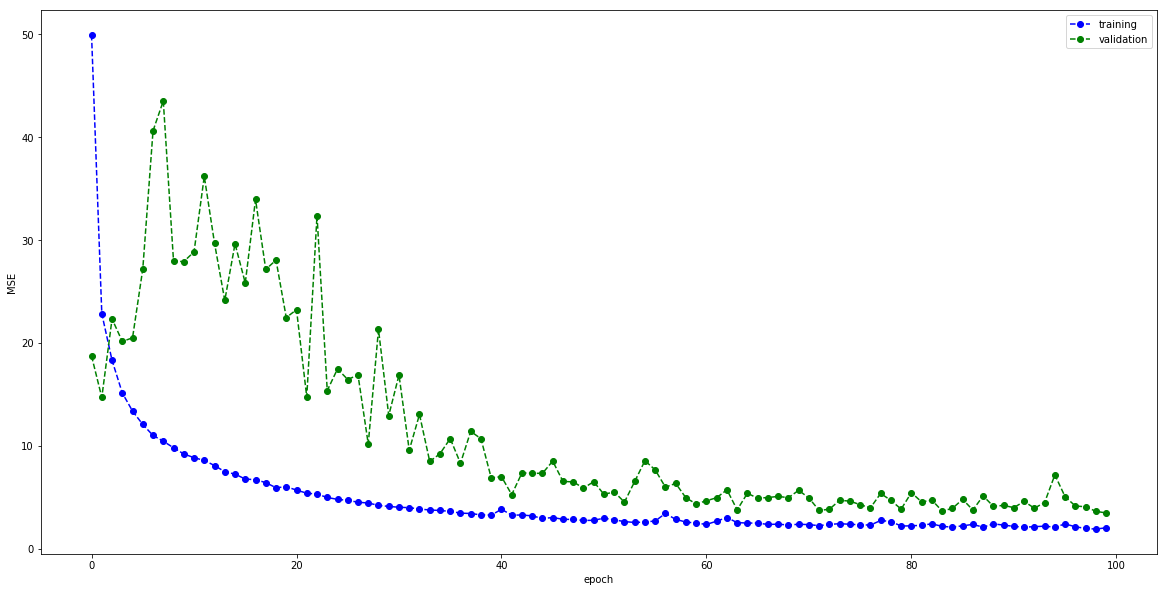

In [13]:
### plot the training and validation loss for each epoch
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(history['loss'], 'bo--')
plt.plot(history['val_loss'], 'go--')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['training', 'validation'])
plt.show()

In [14]:
weights = os.path.join(RUN, "weights.100-3.48.hdf5")
model = build_model(HEIGHT, WIDTH, CHANNEL, lr=0.0005)
model.load_weights(weights)

In [15]:
#Let's load the entire training video and evaluate the MSE on it
train_meta = pd.read_csv(TRAIN_FLOW_META_PATH)

In [16]:
train_meta.head()

,flow_path,speed
0,/home/ubuntu/repositories/speed-challenge/data...,28.105569
1,/home/ubuntu/repositories/speed-challenge/data...,28.106048
2,/home/ubuntu/repositories/speed-challenge/data...,28.118466
3,/home/ubuntu/repositories/speed-challenge/data...,28.119823
4,/home/ubuntu/repositories/speed-challenge/data...,28.098907


In [17]:
def predict(frame):
    for idx in tqdm(range(0, len(frame))):
        row = frame.iloc[[idx]].reset_index()
        flow = cv2.imread(row['flow_path'].values[0])
        flow = cv2.resize(flow, SIZE, interpolation=cv2.INTER_AREA)
        #drop useless channel
        flow = flow[:,:,[0,2]]
        #normalize
        flow = flow / 127.5
        speed = model.predict(np.array([flow]))
        frame.loc[[idx], 'predicted_speed'] = speed[0]

In [18]:
predict(train_meta)


 17%|█▋        | 3405/20399 [00:14<01:14, 229.64it/s]


 33%|███▎      | 6826/20399 [00:29<00:58, 231.16it/s]


 50%|█████     | 10236/20399 [00:44<00:44, 227.47it/s]


 67%|██████▋   | 13606/20399 [00:59<00:29, 230.83it/s]


 83%|████████▎ | 16988/20399 [01:13<00:14, 235.32it/s]


100%|█████████▉| 20372/20399 [01:28<00:00, 230.81it/s]


100%|██████████| 20399/20399 [01:28<00:00, 230.83it/s]

In [19]:
train_meta.head()

,flow_path,speed,predicted_speed
0,/home/ubuntu/repositories/speed-challenge/data...,28.105569,25.460970
1,/home/ubuntu/repositories/speed-challenge/data...,28.106048,26.547102
2,/home/ubuntu/repositories/speed-challenge/data...,28.118466,25.522608
3,/home/ubuntu/repositories/speed-challenge/data...,28.119823,26.733372
4,/home/ubuntu/repositories/speed-challenge/data...,28.098907,25.418928


In [20]:
train_meta["predicted_speed"].min()

0.8992810249328613

In [21]:
#Clip the speed
train_meta.loc[train_meta["predicted_speed"] < 0] = 0

In [22]:
train_meta.tail()

,flow_path,speed,predicted_speed
20394,/home/ubuntu/repositories/speed-challenge/data...,2.346995,1.023094
20395,/home/ubuntu/repositories/speed-challenge/data...,2.309488,1.088941
20396,/home/ubuntu/repositories/speed-challenge/data...,2.291356,0.929803
20397,/home/ubuntu/repositories/speed-challenge/data...,2.276759,0.998771
20398,/home/ubuntu/repositories/speed-challenge/data...,2.233680,0.900500


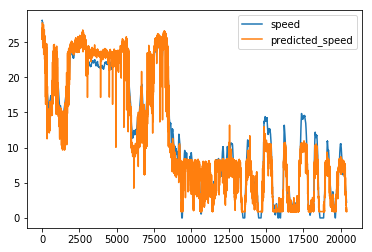

In [23]:
train_meta.plot()

In [24]:
#rolling window
window_size = 30
train_meta['averaged_predicted_speed'] = pd.rolling_median(train_meta['predicted_speed'], window_size, center=True, min_periods=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,min_periods=1,center=True).median()
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
train_meta.head()

,flow_path,speed,predicted_speed,averaged_predicted_speed
0,/home/ubuntu/repositories/speed-challenge/data...,28.105569,25.460970,26.054422
1,/home/ubuntu/repositories/speed-challenge/data...,28.106048,26.547102,26.135235
2,/home/ubuntu/repositories/speed-challenge/data...,28.118466,25.522608,26.216047
3,/home/ubuntu/repositories/speed-challenge/data...,28.119823,26.733372,26.170879
4,/home/ubuntu/repositories/speed-challenge/data...,28.098907,25.418928,26.216047


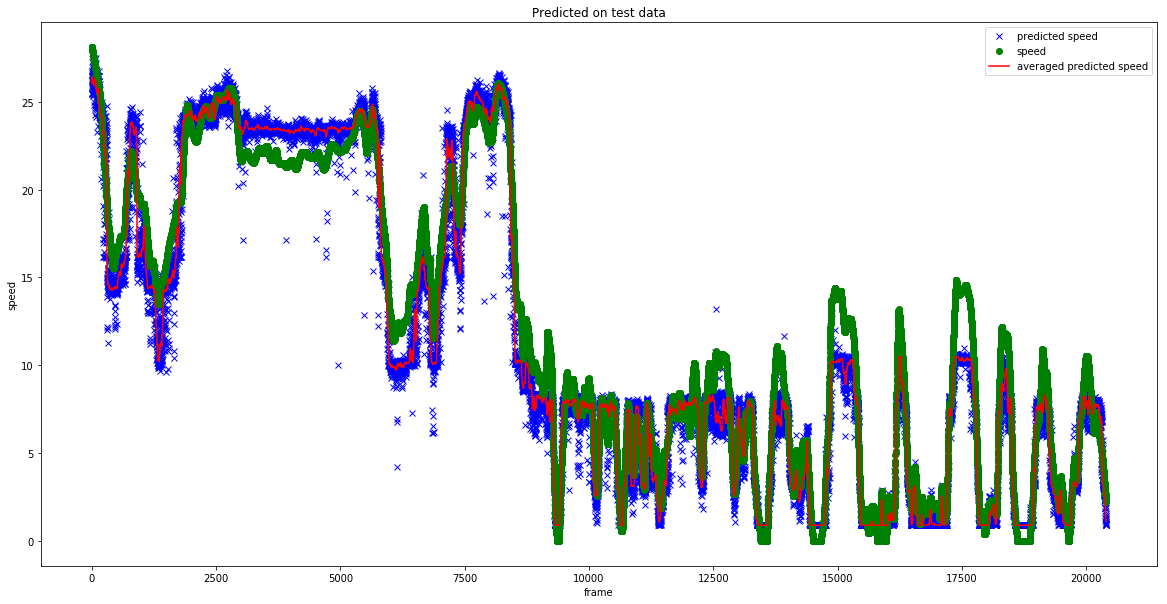

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(train_meta)), 
         train_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['speed']], 'go')
plt.plot(np.arange(len(train_meta)), 
         train_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [27]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 2]))

3.2287424917380583


In [28]:
print(mean_squared_error(train_meta.iloc[1:-1, 1], 
                         train_meta.iloc[1:-1, 3]))

2.7116471462735197


# Prediction

In [29]:
test_meta = pd.read_csv(TEST_FLOW_META_PATH)

In [30]:
test_meta.head()

,flow_path,speed
0,/home/ubuntu/repositories/speed-challenge/data...,0.0
1,/home/ubuntu/repositories/speed-challenge/data...,0.0
2,/home/ubuntu/repositories/speed-challenge/data...,0.0
3,/home/ubuntu/repositories/speed-challenge/data...,0.0
4,/home/ubuntu/repositories/speed-challenge/data...,0.0


In [31]:
predict(test_meta)


 28%|██▊       | 3018/10797 [00:14<00:37, 208.97it/s]


 56%|█████▌    | 6057/10797 [00:29<00:22, 207.13it/s]


 84%|████████▍ | 9105/10797 [00:44<00:08, 203.09it/s]


100%|██████████| 10797/10797 [00:52<00:00, 206.24it/s]

In [32]:
test_meta.head()

,flow_path,speed,predicted_speed
0,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.053749
1,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.139217
2,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.447761
3,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.447897
4,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.403598


In [33]:
test_meta["predicted_speed"].min()

0.8992810249328613

In [34]:
#Clip the speed
test_meta.loc[test_meta["predicted_speed"] < 0] = 0

In [35]:
#rolling window
window_size = 30
test_meta['averaged_predicted_speed'] = pd.rolling_median(test_meta['predicted_speed'], window_size, center=True, min_periods=1)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=30,min_periods=1,center=True).median()
  This is separate from the ipykernel package so we can avoid doing imports until


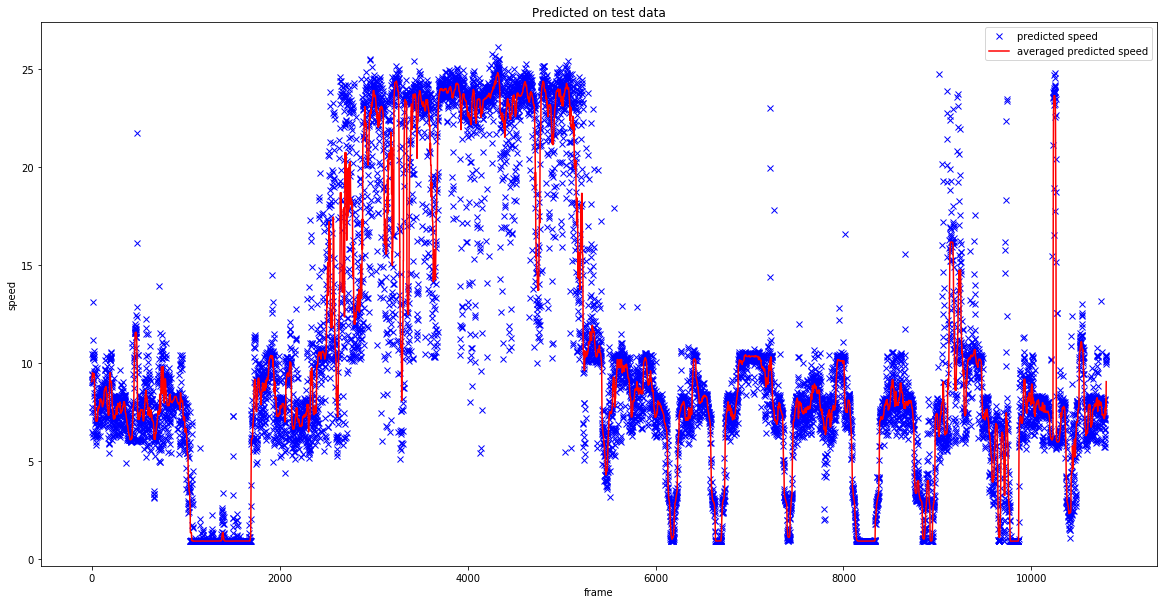

In [36]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(np.arange(len(test_meta)), 
         test_meta[['predicted_speed']], 'bx')
plt.plot(np.arange(len(test_meta)), 
         test_meta[['averaged_predicted_speed']], 'r')
plt.xlabel('frame')
plt.ylabel('speed')
plt.title('Predicted on test data')
plt.legend(['predicted speed', 'averaged predicted speed'], loc='upper right')
plt.show()
plt.close()

In [37]:
cv2.VideoWriter_fourcc(*'MJPG')
rec = cv2.VideoWriter('flow.avi',cv2.VideoWriter_fourcc(*'MJPG'),20,(300,300))
test_raw_meta = pd.read_csv(TEST_META_PATH)


In [38]:
len(test_raw_meta)

10798

In [40]:
print(len(test_meta))
test_meta.head()

10797


,flow_path,speed,predicted_speed,averaged_predicted_speed
0,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.053749,9.048146
1,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.139217,9.050948
2,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.447761,9.053749
3,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.447897,9.096483
4,/home/ubuntu/repositories/speed-challenge/data...,0.0,9.403598,9.139217


In [41]:
#Add one more row to test_meta by copying the last row
last_speed = test_meta.iloc[[len(test_meta) - 1]]["averaged_predicted_speed"].values[0]
test_meta_extended = test_meta.append([{'averaged_predicted_speed': last_speed}], ignore_index=True)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/frame.py:5186: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  other = other.loc[:, self.columns]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:1367: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [42]:
print(len(test_meta_extended))
test_meta_extended.tail()

10798


,flow_path,speed,predicted_speed,averaged_predicted_speed
10793,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.431912,8.129603
10794,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.192885,7.670661
10795,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.303463,8.129603
10796,/home/ubuntu/repositories/speed-challenge/data...,0.0,10.076348,9.048052
10797,NaN,NaN,NaN,9.048052


In [43]:
#Write the result on disk
test_meta_extended.to_csv(TEST_TEXT_PATH, columns = ["averaged_predicted_speed"], index=False, header=False)

# Video with a prediction overlay

In [44]:
test_raw_meta.head()

,frame_path,frame_index,speed
0,/home/ubuntu/repositories/speed-challenge/data...,0,0
1,/home/ubuntu/repositories/speed-challenge/data...,1,0
2,/home/ubuntu/repositories/speed-challenge/data...,2,0
3,/home/ubuntu/repositories/speed-challenge/data...,3,0
4,/home/ubuntu/repositories/speed-challenge/data...,4,0


In [46]:
for index, row in tqdm(test_raw_meta.iterrows()):
    frame = cv2.imread(row["frame_path"])
    frame = cv2.resize(frame, (300, 300), interpolation=cv2.INTER_AREA)
    try:
        speed = test_meta.iloc[[index]]['averaged_predicted_speed'].values[0]
    except IndexError:
        speed = 0
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(frame,"Speed: " + str(speed),(5,15),font, 0.55,(255,255,255),2)
    rec.write(frame)
rec.release()


0it [00:00, ?it/s]
1it [00:00,  2.28it/s]
12it [00:00,  3.23it/s]
23it [00:00,  4.56it/s]
35it [00:00,  6.40it/s]
46it [00:00,  8.93it/s]
58it [00:00, 12.32it/s]
69it [00:01, 16.79it/s]
80it [00:01, 22.47it/s]
91it [00:01, 29.52it/s]
103it [00:01, 37.88it/s]
114it [00:01, 47.13it/s]
125it [00:01, 56.86it/s]
137it [00:01, 66.58it/s]
149it [00:01, 76.01it/s]
161it [00:01, 83.99it/s]
173it [00:01, 91.05it/s]
185it [00:02, 96.39it/s]
197it [00:02, 101.57it/s]
209it [00:02, 106.15it/s]
221it [00:02, 108.26it/s]
233it [00:02, 110.05it/s]
245it [00:02, 110.15it/s]
257it [00:02, 111.42it/s]
269it [00:02, 111.42it/s]
281it [00:02, 112.01it/s]
293it [00:03, 112.35it/s]
305it [00:03, 112.75it/s]
317it [00:03, 112.43it/s]
329it [00:03, 112.13it/s]
341it [00:03, 112.20it/s]
353it [00:03, 111.27it/s]
365it [00:03, 110.42it/s]
377it [00:03, 109.43it/s]
388it [00:03, 108.39it/s]
399it [00:04, 107.06it/s]
410it [00:04, 106.67it/s]
421it [00:04, 107.63it/s]
433it [00:04, 108.61it/s]
445it [00:04, 110.6

3241it [00:31, 30.60it/s]
3253it [00:31, 39.12it/s]
3265it [00:31, 48.89it/s]
3277it [00:31, 58.85it/s]
3289it [00:31, 69.43it/s]
3301it [00:31, 79.03it/s]
3313it [00:31, 87.68it/s]
3325it [00:31, 94.65it/s]
3337it [00:32, 100.34it/s]
3349it [00:32, 105.20it/s]
3361it [00:32, 107.50it/s]
3373it [00:32, 110.54it/s]
3385it [00:32, 112.55it/s]
3397it [00:32, 113.47it/s]
3409it [00:32, 114.52it/s]
3421it [00:32, 115.84it/s]
3433it [00:32, 116.41it/s]
3445it [00:32, 116.04it/s]
3457it [00:33, 117.10it/s]
3469it [00:33, 117.12it/s]
3481it [00:33, 117.33it/s]
3493it [00:33, 116.59it/s]
3505it [00:33, 116.00it/s]
3517it [00:33, 115.50it/s]
3529it [00:33, 115.98it/s]
3541it [00:33, 116.83it/s]
3553it [00:33, 116.55it/s]
3565it [00:33, 116.60it/s]
3577it [00:34, 116.46it/s]
3589it [00:34, 116.46it/s]
3601it [00:34, 115.08it/s]
3613it [00:34, 114.96it/s]
3625it [00:34, 114.58it/s]
3637it [00:34, 114.29it/s]
3649it [00:34, 113.95it/s]
3661it [00:34, 113.68it/s]
3673it [00:34, 114.05it/s]
3685it [0

6515it [00:59, 111.85it/s]
6527it [00:59, 111.00it/s]
6539it [00:59, 111.12it/s]
6551it [00:59, 109.62it/s]
6562it [01:00, 109.60it/s]
6573it [01:00, 109.06it/s]
6585it [01:00, 109.50it/s]
6596it [01:00, 109.46it/s]
6607it [01:00, 108.29it/s]
6618it [01:00, 108.20it/s]
6629it [01:00, 107.61it/s]
6640it [01:00, 106.70it/s]
6651it [01:00, 106.70it/s]
6662it [01:01, 107.01it/s]
6673it [01:01, 106.45it/s]
6685it [01:01, 107.56it/s]
6696it [01:01, 108.00it/s]
6707it [01:01, 107.45it/s]
6719it [01:01, 107.95it/s]
6730it [01:01, 108.27it/s]
6742it [01:01, 109.52it/s]
6753it [01:01, 108.95it/s]
6764it [01:01, 109.09it/s]
6775it [01:02, 108.14it/s]
6787it [01:02, 110.05it/s]
6799it [01:02, 111.97it/s]
6811it [01:02, 112.05it/s]
6823it [01:02, 110.97it/s]
6835it [01:02, 110.29it/s]
6847it [01:02, 110.40it/s]
6859it [01:02, 110.76it/s]
6871it [01:02, 111.16it/s]
6883it [01:03, 110.42it/s]
6895it [01:03, 110.16it/s]
6907it [01:03, 109.97it/s]
6919it [01:03, 110.07it/s]
6931it [01:03, 109.65it/s]
6

9734it [01:30, 110.39it/s]
9746it [01:30, 110.55it/s]
9758it [01:30, 110.15it/s]
9770it [01:30, 109.44it/s]
9782it [01:30, 110.03it/s]
9794it [01:30, 107.45it/s]
9805it [01:31, 107.43it/s]
9816it [01:31, 107.45it/s]
9827it [01:31, 106.37it/s]
9838it [01:31, 106.42it/s]
9849it [01:31, 106.19it/s]
9860it [01:31, 107.03it/s]
9871it [01:31, 107.61it/s]
9882it [01:31, 107.12it/s]
9893it [01:31, 106.82it/s]
9905it [01:32, 107.84it/s]
9916it [01:32, 108.10it/s]
9927it [01:32, 108.24it/s]
9938it [01:32, 108.05it/s]
9949it [01:32, 108.36it/s]
9960it [01:32, 107.29it/s]
9971it [01:32, 107.68it/s]
9983it [01:32, 109.13it/s]
9995it [01:32, 109.57it/s]
10007it [01:32, 110.48it/s]
10019it [01:33, 111.72it/s]
10031it [01:33, 111.59it/s]
10043it [01:33, 111.69it/s]
10055it [01:33, 113.01it/s]
10067it [01:33, 113.21it/s]
10079it [01:33, 113.50it/s]
10091it [01:33, 114.36it/s]
10103it [01:33, 114.95it/s]
10115it [01:33, 114.90it/s]
10127it [01:33, 115.48it/s]
10139it [01:34, 114.24it/s]
10151it [01:34, 